# **Loan Approval Prediction**

In [1]:
# import libraries

import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate


# Import libraries for model building
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_selection import RFE
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier


In [2]:
# import the data
df_train = pd.read_csv('df_train.csv', index_col = 'id')
df_test = pd.read_csv('df_test.csv', index_col = 'id')
df_train.shape, df_test.shape

((58642, 13), (39098, 12))

In [3]:
# drop column person_age
df_train.drop('person_age', axis = 1, inplace = True)
df_test.drop('person_age', axis = 1, inplace = True)
df_train.head()

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,age_cat
id,,,,,,,,,,,,
0,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,36-40
1,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,20-25
2,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,26-30
3,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,31-35
4,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,20-25


In [4]:
# Split the data
X_train = df_train.drop(['loan_status'], axis = 1).reset_index(drop = True)
X_test = df_test.reset_index(drop = True)
y = df_train.loc[:,'loan_status']

### **Data Transformation**

- Ordinal Variables :loan_grade : OrdinalEncoding
- Nominal Variables :person_home_ownership, loan_intent , cb_person_default_on_file, age_cat : OneHotEncoding

In [7]:
dummies_col = ['person_home_ownership', 'loan_intent' , 'cb_person_default_on_file', 'age_cat', "loan_grade"]

numerical_features = X_train.select_dtypes(include = ['int64', 'float64']).columns

In [8]:
X_train[dummies_col].nunique()

person_home_ownership         4
loan_intent                   6
cb_person_default_on_file     2
age_cat                      11
loan_grade                    7
dtype: int64

In [9]:
len(numerical_features)

6

The dataset contains both categorical and numerical features. To develop a model, we need to convert all categorical values into numerical values and scale all numerical features. If we perform these steps separately, there is a risk of data leakage. To prevent this, I use the ColumnTransformer. This function allows me to easily retain the column names after transformation.

In [11]:
ct = ColumnTransformer(
    [('scaler', StandardScaler(),numerical_features,),  # scaling on numeric features, 6 columns
      # OHE on categorical features, drop = first to avoid multicollinary and dealing at the same time with the binary columns, we will have 25 columns
    ('onehot', OneHotEncoder(drop="first", dtype=int, sparse_output=False), dummies_col)]  # OHE on categorical features,   
    )

# finally we will have 31 columns 
ct

ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                 Index(['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               dtype=<class 'int'>,
                                               sparse_output=False),
                                 ['person_home_ownership', 'loan_intent',
                                  'cb_person_default_on_file', 'age_cat',
                                  'loan_grade'])])

#### **DecisionTreeClassifier baseline**

To assess the data, I first developed a Decision Tree classifier as a baseline to get an initial understanding of the model's performance. The scoring metric chosen is ROC-AUC, as the dataset is highly unbalanced. The Receiver Operating Characteristic (ROC) curve considers all possible thresholds for a given classifier using predict_proba. Instead of focusing on precision and recall, it plots the False Positive Rate (FPR) and True Positive Rate (TPR, or recall).

False Positive Rate (FPR) is calculated as: 
FPR = FP / (FP +TN)

We aim for a lower FPR and a higher TPR to improve the classifier's performance.

AUC of 0.5 indicates random chance, meaning the model is no better than guessing.
The AUC can be interpreted as evaluating the ranking of positive examples. It answers the question: What is the probability that a randomly selected positive point will have a higher score than a randomly selected negative point according to the classifier?


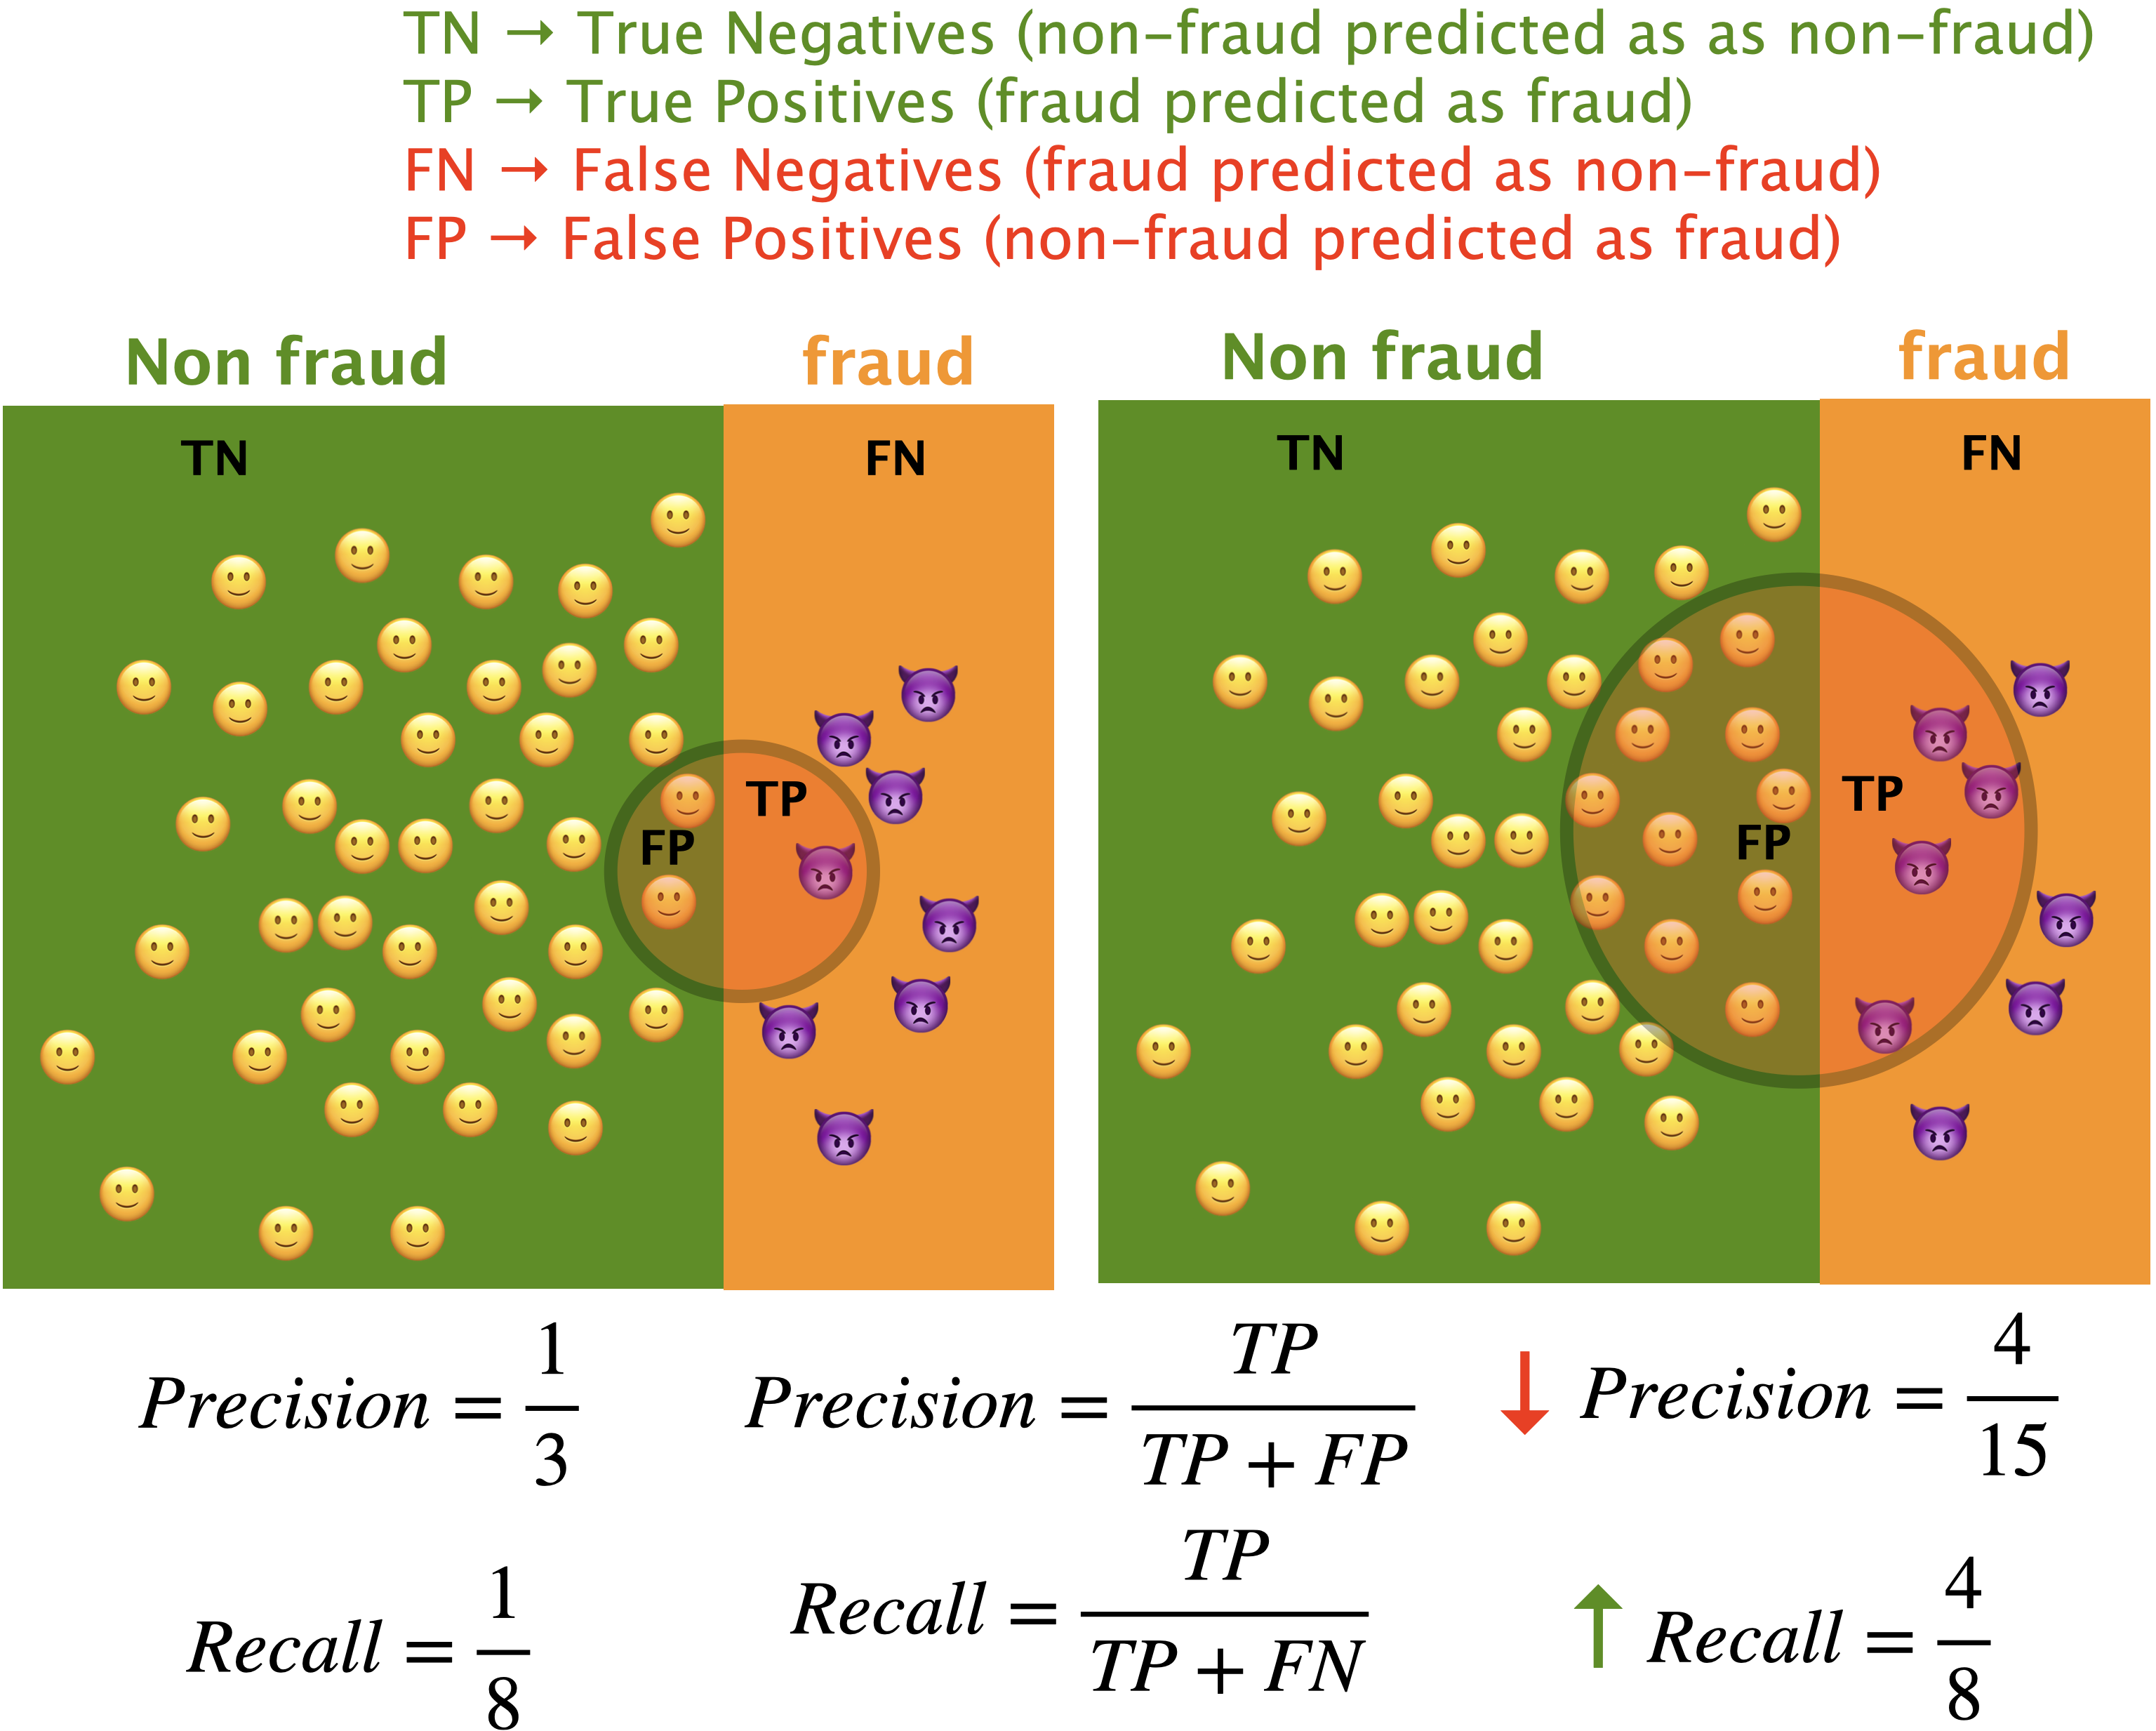



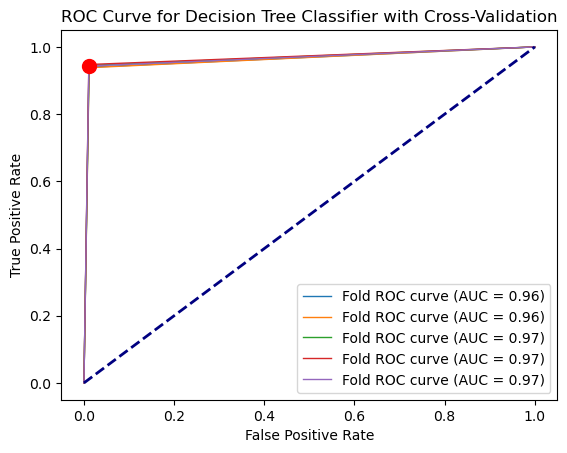

In [14]:
# choose scoring roc_auc as the data is highly unbalanced

pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
result = cross_validate(
    pipe_dt, X_train, y ,  cv=5, return_train_score=True, scoring="roc_auc", return_estimator=True)

for estimator in result['estimator']:
    # Get predicted probabilities for the positive class
    y_probs = estimator.predict_proba(X_train)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds  = roc_curve(y, y_probs)
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve for each fold
    plt.plot(fpr, tpr, lw=1, label=f'Fold ROC curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier with Cross-Validation')
plt.legend(loc='lower right')

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)

# Show the plot
plt.show()

In [15]:
result["test_score"].mean()

0.8290026597859278

In [16]:
# Define pipeline
logreg = LogisticRegression()
pipe_lr = make_pipeline(ct, logreg)

# Define parameter grid for logistic regression
param_logreg = {
    "logisticregression__C": [100, 10, 1.0, 0.1, 0.01]
}

# Create and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe_lr,
    param_distributions=param_logreg,
    scoring="roc_auc", 
    n_iter=10,  # Number of parameter combinations to sample
    n_jobs=-1,
    return_train_score=True,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y)

C:\Users\samir\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               Index(['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             dtype=<class 'int'>,
                                                                                             sparse_output=False),
                                                                               ['person_home_ownership',
                                                                                'loan_intent',
                                                                                'cb_person_default_on_file',
                                                                                'age_cat',
                                                                                'loan_grade'])])),
                                             ('logisticregression',
                                              LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions={'logisticregression__C': [100, 10, 1.0,
                                                                  0.1, 0.01]},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [17]:
random_search.best_score_ 

0.9018856230673429

In [18]:
random_search.best_params_

{'logisticregression__C': 1.0}

In [19]:
pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score"
    ]
].set_index("rank_test_score").sort_index().T

rank_test_score,1,2,3,4,5
mean_test_score,0.901886,0.901860,0.901816,0.901754,0.900714
mean_train_score,0.902415,0.902306,0.902372,0.902341,0.901031
param_logisticregression__C,1.000000,0.100000,10.000000,100.000000,0.010000
mean_fit_time,0.628898,0.514580,0.808818,0.904392,0.411168


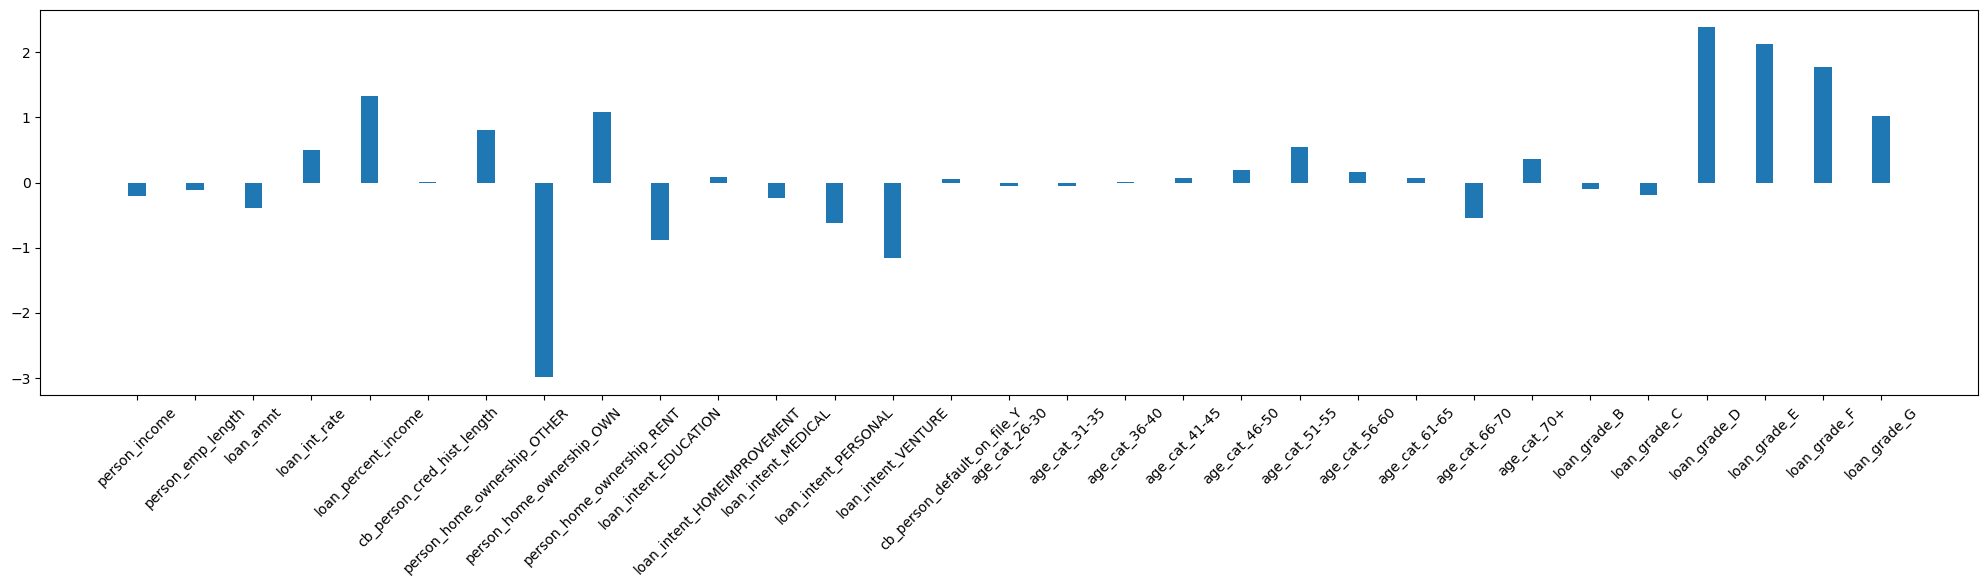

In [20]:
logreg = LogisticRegression( C = 1)
pipe_lr = make_pipeline(ct, logreg)
pipe_lr.fit(X_train, y)
categorical_feature_names = ct.named_transformers_["onehot"].get_feature_names_out(dummies_col).tolist()
feature_names = list(numerical_features) + categorical_feature_names


fig = plt.subplots(figsize =(25, 5)) 
plt.bar(feature_names,logreg.coef_[0], width= 0.3)
plt.xticks(rotation = 45);

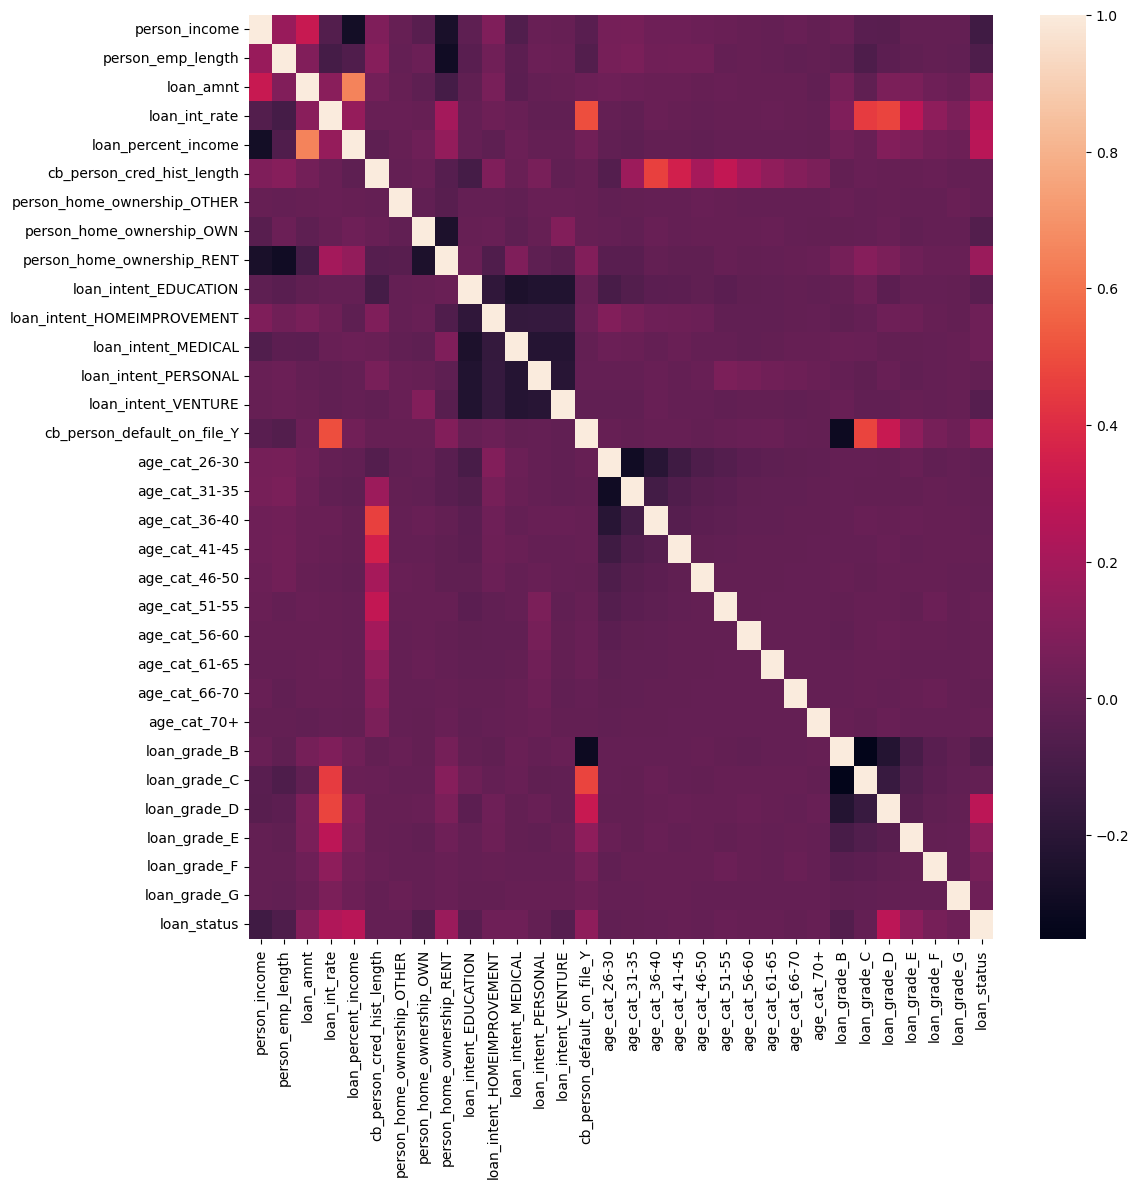

In [21]:
X_train_pre = X_train.copy(deep = True)
X_train_trans = pd.DataFrame(ct.fit_transform(X_train_pre), columns = feature_names)
df = pd.concat((X_train_trans, y), axis = 1)
plt.figure(figsize = (12,12))
sns.heatmap(df.corr());

In [22]:
df_coef = pd.DataFrame(logreg.coef_[0], index = feature_names, columns = ["Coefficient"])
df_coef.sort_values(by = ["Coefficient"], ascending = False)

,Coefficient
loan_grade_D,2.380301
loan_grade_E,2.120665
loan_grade_F,1.776483
loan_percent_income,1.329828
person_home_ownership_RENT,1.090667
loan_grade_G,1.014779
person_home_ownership_OTHER,0.806584
age_cat_51-55,0.548006
loan_int_rate,0.502982
age_cat_70+,0.361782


In [23]:
df_coef["Coefficient"].describe()

count    31.000000
mean      0.162732
std       0.999441
min      -2.992252
25%      -0.195779
50%       0.053398
75%       0.525494
max       2.380301
Name: Coefficient, dtype: float64

In [25]:
df_low_coef = df_coef[df_coef["Coefficient"] < df_coef["Coefficient"].median()]
df_low_coef.index, len(df_low_coef.index)

(Index(['person_income', 'person_emp_length', 'loan_amnt',
        'cb_person_cred_hist_length', 'person_home_ownership_OWN',
        'loan_intent_EDUCATION', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL',
        'loan_intent_VENTURE', 'age_cat_26-30', 'age_cat_31-35',
        'age_cat_36-40', 'age_cat_66-70', 'loan_grade_B', 'loan_grade_C'],
       dtype='object'),
 15)

### **Predictive Model**

In [34]:
rfe = RFE(Ridge(), n_features_to_select=15)
pipe = make_pipeline(ct,rfe,  GradientBoostingClassifier())


param_model = {
    'rfe__n_features_to_select' : [15,20, 25, 31],
    'gradientboostingclassifier__n_estimators' : [10, 100] ,
    'gradientboostingclassifier__learning_rate' : [ 0.01, 0.1],
    'gradientboostingclassifier__subsample' : [0.5, 1.0],
    'gradientboostingclassifier__max_depth' : [3,5, 9]
}

# Create and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_model,
    scoring="roc_auc", 
    n_iter=10,  # Number of parameter combinations to sample
    n_jobs=-1,
    return_train_score=True,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               StandardScaler(),
                                                                               Index(['person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                                                              ('onehot',
                                                                               OneHotEncoder(drop='first',
                                                                                             dtype=<class 'int'>,
                                                                                             sparse_output=False),
                                                                               ['p...
                                              GradientBoostingClassifier())]),
                   n_jobs=-1,
                   param_distributions={'gradientboostingclassifier__learning_rate': [0.01,
                                                                                      0.1],
                                        'gradientboostingclassifier__max_depth': [3,
                                                                                  5,
                                                                                  9],
                                        'gradientboostingclassifier__n_estimators': [10,
                                                                                     100],
                                        'gradientboostingclassifier__subsample': [0.5,
                                                                                  1.0],
                                        'rfe__n_features_to_select': [15, 20,
                                                                      25, 31]},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [35]:
df_result = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        'mean_train_score',
        'param_rfe__n_features_to_select',
        'param_gradientboostingclassifier__subsample',
        'param_gradientboostingclassifier__n_estimators',
        'param_gradientboostingclassifier__max_depth',
        'param_gradientboostingclassifier__learning_rate',        
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

best_result = df_result[df_result['mean_test_score'] == df_result['mean_test_score'].max()]
best_result

,mean_test_score,mean_train_score,param_rfe__n_features_to_select,param_gradientboostingclassifier__subsample,param_gradientboostingclassifier__n_estimators,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__learning_rate,mean_fit_time
rank_test_score,,,,,,,,
1,0.950898,0.993525,25,1.0,100,9,0.1,50.9829


In [ ]:
from xgboost import XGBClassifier

# Define RFE and pipeline
rfe = RFE(Ridge(), n_features_to_select=15)
pipe = make_pipeline(ct, rfe, XGBClassifier(use_label_encoder=False, eval_metric='logloss'))

# Define hyperparameter space for XGBClassifier
param_model = {
    'rfe__n_features_to_select' : [15,20, 25, 31],
    'xgbclassifier__n_estimators': [10, 100, 500],  # Number of boosting iterations
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'xgbclassifier__max_depth': [6, 9, 12],  # Maximum tree depth
    'xgbclassifier__subsample': [0.8, 0.9, 1.0],  # Subsampling ratio
    'xgbclassifier__colsample_bytree': [0.8, 0.9, 1.0],  # Column subsampling ratio
    'xgbclassifier__gamma': [0, 0.1, 1.0],  # Minimum loss reduction for a split
    'xgbclassifier__reg_alpha': [0.0, 0.1, 1.0],  # L1 regularization term
    'xgbclassifier__reg_lambda': [0.0, 0.1, 1.0]  # L2 regularization term
}

# Create and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_model,
    scoring="roc_auc", 
    n_iter=10,  # Number of parameter combinations to sample
    n_jobs=-1,
    return_train_score=True,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y)

# Compile results into a DataFrame
df_result = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        'mean_train_score',
        'param_rfe__n_features_to_select',
        'param_xgbclassifier__n_estimators',
        'param_xgbclassifier__learning_rate',
        'param_xgbclassifier__max_depth',
        'param_xgbclassifier__subsample',
        'param_xgbclassifier__colsample_bytree',
        'param_xgbclassifier__gamma',
        'param_xgbclassifier__reg_alpha',
        'param_xgbclassifier__reg_lambda',
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

# Extract the best result
best_result = df_result[df_result['mean_test_score'] == df_result['mean_test_score'].max()]
best_result


In [ ]:
from lightgbm.sklearn import LGBMClassifier

pipe = make_pipeline(ct, rfe,  LGBMClassifier())


# Define hyperparameter space for LGBMClassifier
param_model = {
    'rfe__n_features_to_select' : [15,20, 25, 31],
    'lgbmclassifier__n_estimators': [10, 100],  # Number of boosting iterations
    'lgbmclassifier__learning_rate': [0.05, 0.1, 1],  # Learning rate
    'lgbmclassifier__max_depth': [6, 9],  # Maximum tree depth (-1 means no limit)
    'lgbmclassifier__reg_lambda': [ 0.1, 1.0]  # L2 regularization term
}

# Create and fit RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_model,
    scoring="roc_auc", 
    n_iter=10,  # Number of parameter combinations to sample
    n_jobs=-1,
    return_train_score=True,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y)

# Compile results into a DataFrame
df_result = pd.DataFrame(random_search.cv_results_)[
    [
        "mean_test_score",
        'mean_train_score',
        'param_rfe__n_features_to_select',       
        'param_lgbmclassifier__n_estimators',
        'param_lgbmclassifier__learning_rate',
        'param_lgbmclassifier__max_depth',
        'param_lgbmclassifier__reg_lambda',
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()

# Extract the best result
best_result = df_result[df_result['mean_test_score'] == df_result['mean_test_score'].max()]
best_result